## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv". 

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available as shuttle.csv

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model. 

**Hint**: it should not take long to run a 1000 epochs. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies. 


**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

**Task 4: VAE**

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

In [127]:
#%reset

### Imports

In [1]:
import tensorflow as tf

In [2]:
# GPU code only, skip if no GPU is available!
# make sure we don't run out of memory by running multiple Notebooks together
# https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices('GPU') 
try:
    print(physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except Exception as e: 
    # Invalid device or cannot modify virtual devices once initialized. 
    print('Error', e)
    pass

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from scipy import stats

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

import os
import keras

Using TensorFlow backend.


In [6]:
print(keras.__version__)
print(tf.__version__)
print(np.__version__)

2.3.1
2.1.0
1.17.4


In [4]:
# Define a function which plots losses across
# the different epochs.
def plot_loss(H, metrics):
    N = np.arange(0, len(H.history["loss"]))
    plt.figure()
    for m in metrics:
        plt.plot(N, H.history[m], label=m)
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

### Task 1: data preprocessing

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.

In [5]:
shuttle_df = pd.read_csv('shuttle.csv')

In [6]:
shuttle_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Anom
0,50,21,77,0,28,0,27,48,22,1
1,53,0,82,0,52,-5,29,30,2,0
2,37,0,76,0,28,18,40,48,8,0
3,37,0,79,0,34,-26,43,46,2,0
4,85,0,88,-4,6,1,3,83,80,1


In [7]:
shuttle_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Anom
count,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000
mean,46.932399,-0.063955,85.123124,0.213231,36.871784,2.160030,38.200725,48.288592,10.261930,0.071511
std,12.875159,84.674481,8.877517,37.579171,19.963113,218.324964,13.446306,20.572064,23.751024,0.257680
min,27.000000,-4821.000000,21.000000,-3939.000000,-188.000000,-26739.000000,-48.000000,-353.000000,-356.000000,0.000000
25%,37.000000,0.000000,79.000000,0.000000,30.000000,-4.000000,33.000000,35.000000,0.000000,0.000000
50%,44.000000,0.000000,83.000000,0.000000,42.000000,0.000000,39.000000,41.000000,2.000000,0.000000
75%,50.000000,0.000000,88.000000,0.000000,46.000000,5.000000,43.000000,55.000000,6.000000,0.000000
max,126.000000,5075.000000,149.000000,3830.000000,436.000000,15164.000000,105.000000,270.000000,266.000000,1.000000


In [8]:
# make sure we don't have any missing data
shuttle_df.isnull().sum()

V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
Anom    0
dtype: int64

In [9]:
# since the task says "we do not know which samples are anomalous",
# we can't use a simple train/test split from sklearn,
# instead we can shuffle the dataset and take first 80% for training
shuttle_vals = shuttle_df.values
shuttle_vals_origin = shuttle_vals.copy()
np.random.seed(42)
np.random.shuffle(shuttle_vals) # this shuffle is an in-place operation

In [10]:
# split data into X and y (where y will be only used afterwards to verify the results)
X = shuttle_vals[:, 0:9]
y = shuttle_vals[:, 9]

In [11]:
# split X and y into train and test,
# 10000 samples will represent ~20% of the data,
# I could you the standard train/test split, but wanted
# for once to try the manual way
X_train, X_test = X[10000:,:], X[:10000,:] 
y_train, y_test = y[10000:], y[:10000]

In [12]:
# a little bit of cheating (just for inspection and sanity purpose):
# make sure we do have outliers in the train & test sets
print('train: ', y_train[y_train==1].shape[0], '/', y_train.shape[0])
print('test:  ', y_test[y_test==1].shape[0], '/', y_test.shape[0])

train:  2775 / 39097
test:   736 / 10000


Feature idx: V1


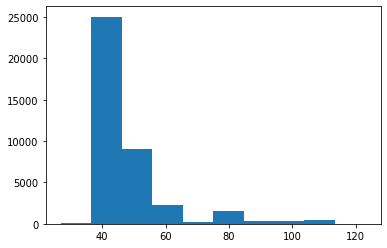

Feature idx: V2


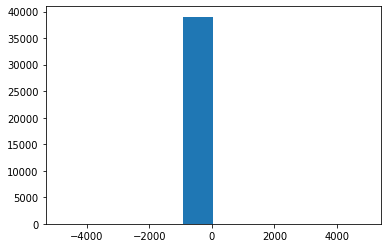

Feature idx: V3


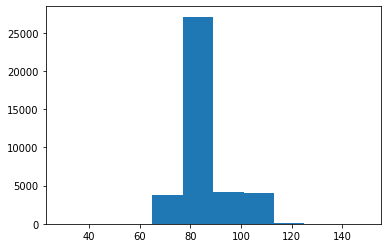

Feature idx: V4


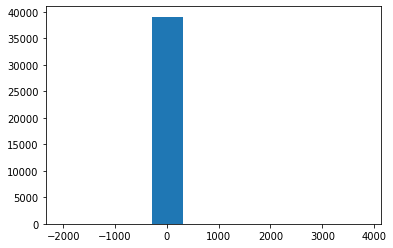

Feature idx: V5


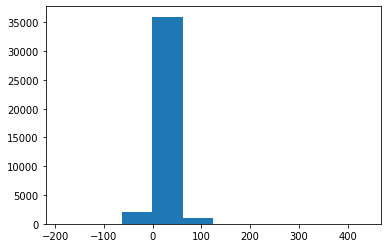

Feature idx: V6


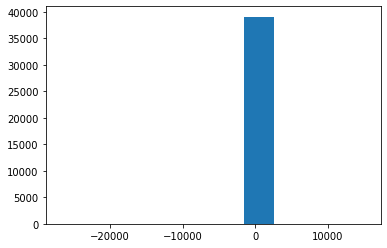

Feature idx: V7


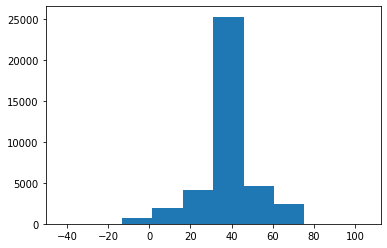

Feature idx: V8


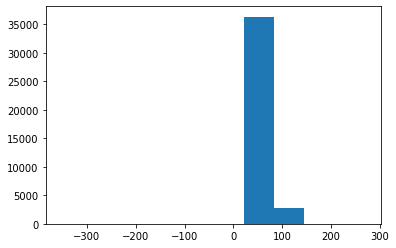

Feature idx: V9


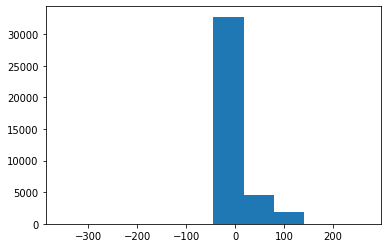

In [13]:
# check the histogram of values for each feature in the training sample
cols = shuttle_df.columns
for i in range(X_train.shape[1]):
    print(f'Feature idx: {cols[i]}')
    plt.hist(X_train[:, i])
    plt.show()

Note: We can see that the range of values and outliers is pretty significant, but removing those in the pre-processing stage did not improve the overall model performance, so I eventually decided to keep them

In [14]:
# Scale the data with respect to the training data set,
# I found that MinMaxScaler performs much better on this dataset
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Scaling the test set using the transform defined by the train set.
X_test_scaled = scaler.transform(X_test)

In [15]:
# check min, max values in the training data
print('min orig.: ', np.amin(X_train))
print('max orig.: ', np.amax(X_train))
print('min scaled: ', np.amin(X_train_scaled))
print('max scaled: ', np.amax(X_train_scaled))

min orig.:  -26739
max orig.:  15164
min scaled:  0.0
max scaled:  1.0


### Task 2: model generation and training

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 62        
_________________________________________________________________
decoder (Model)              (None, 9)                 69        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None


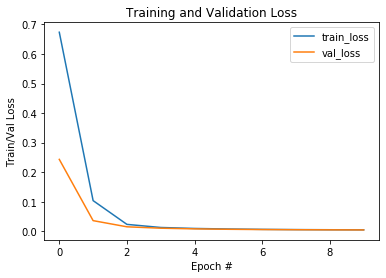

train loss: max= 0.673584654318203 min= 0.004971416483957398
val loss: max= 0.243400035238266 min= 0.004721367450803518


In [110]:
# model parameters
input_dim = X_train_scaled.shape[1]
hidden_dim = 5
latent_dim = 2
activation = 'selu'
kernel_init = 'he_normal'
epochs = 10

# input
input_layer = Input(shape=(input_dim,))

# encoder
x = Dense(units=hidden_dim, activation=activation, kernel_initializer=kernel_init, activity_regularizer=regularizers.l1(10e-5))(input_layer)
z = Dense(units=latent_dim, activation=activation, kernel_initializer=kernel_init)(x)
encoder = Model(input_layer, z, name='encoder')
#print(encoder.summary())
#print('*******************')

# decoder
lats = Input(shape=(latent_dim,), name='latent')
x = Dense(units=hidden_dim, activation=activation, kernel_initializer=kernel_init, activity_regularizer=regularizers.l1(10e-5))(lats)
rec = Dense(units=input_dim, activation=activation, kernel_initializer=kernel_init)(x)
decoder = Model(lats, rec, name='decoder')
#print(decoder.summary())
#print('*******************')

# auto-encoder
# The autoencoder takes the image as input encodes it, then decodes it
rec = decoder(encoder(input_layer))
autoencoder = Model(input_layer, rec, name='autoencoder')
print(autoencoder.summary())

# define optimizer and compile model
opt = Adam(lr=1e-3)
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

# train
history = autoencoder.fit(X_train_scaled, X_train_scaled, epochs=epochs, batch_size=256,
                          validation_data=(X_test_scaled, X_test_scaled), verbose=0)

# plot loss
plot_loss(history, ['loss', 'val_loss'])
print('train loss: max=', max(history.history["loss"]), 'min=', min(history.history["loss"]))
print('val loss: max=', max(history.history["val_loss"]), 'min=', min(history.history["val_loss"]))

#### Training Results:
Model seems to be converging nicely based on the curves above

### Task 3: anomaly detection

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%

In [111]:
# Reconstruct records usign the auto-encoder
reconstructed_data = autoencoder.predict(X_test_scaled)

# calculate error of reconstructed data vs original (we are working in the scaled space)
mse = np.mean(np.power(X_test_scaled - reconstructed_data, 2), axis=1)

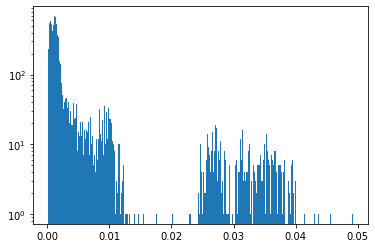

In [125]:
# plot errors on a logarithmic scale
plt.hist(mse[mse < 0.06], bins='auto', log=True)
plt.show()

In [113]:
# add errors to a dataframe
final_df = pd.DataFrame(X_test, columns=shuttle_df.columns[:9])
final_df['mse'] = mse
final_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,mse
0,54,0,81,-5,54,0,27,27,0,0.001550
1,49,0,76,-3,50,7,27,27,0,0.001994
2,47,-3,82,0,46,0,34,35,0,0.000542
3,37,0,108,-7,26,0,71,82,12,0.011993
4,51,-1,81,0,50,-16,30,32,2,0.000909


In [114]:
# verify error distribution
final_df['mse'].describe()

count    10000.000000
mean         0.004271
std          0.020579
min          0.000132
25%          0.000715
50%          0.001285
75%          0.002005
max          1.831696
Name: mse, dtype: float64

In [115]:
# find anomalies
anomaly_rate = 1 - 0.07
mse_threshold = np.quantile(final_df['mse'], anomaly_rate)
print('mse_threshold: ', mse_threshold)

mse_threshold:  0.02436235597303907


In [116]:
# set outlier binary flag
final_df['MSE_Outlier'] = 0
final_df.loc[final_df['mse'] > mse_threshold, 'MSE_Outlier'] = 1
print(f'Found total of {final_df["MSE_Outlier"].sum()} outliers') # sanity check

Found total of 700 outliers


In [117]:
# now add the actual known label, so we can validate if the predictions are correct
final_df['True_Anom_Label'] = y_test

# calculate error between the preditions and true values
final_df['IS_CORRECT'] = final_df['MSE_Outlier'] == final_df['True_Anom_Label']
final_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,mse,MSE_Outlier,True_Anom_Label,IS_CORRECT
0,54,0,81,-5,54,0,27,27,0,0.001550,0,0,True
1,49,0,76,-3,50,7,27,27,0,0.001994,0,0,True
2,47,-3,82,0,46,0,34,35,0,0.000542,0,0,True
3,37,0,108,-7,26,0,71,82,12,0.011993,0,0,True
4,51,-1,81,0,50,-16,30,32,2,0.000909,0,0,True


In [118]:
# verify how many correct and incorrect predictions do we have
final_df['IS_CORRECT'].value_counts()

True     9952
False      48
Name: IS_CORRECT, dtype: int64

In [119]:
# verify for true outliers
final_df[final_df['True_Anom_Label'] == 1]['IS_CORRECT'].value_counts()

True     694
False     42
Name: IS_CORRECT, dtype: int64

In [120]:
# calculate F1 Score, which is a measurement, which combines both: Type 1 and Type 2 errors into a single metric
# F1 = 2 * (precision * recall) / (precision + recall)
sklearn_f1_score = f1_score(final_df['True_Anom_Label'], final_df['MSE_Outlier'])
print('F1 Score:', sklearn_f1_score)

F1 Score: 0.9665738161559889


In [121]:
# verify precision
precision = precision_score(final_df['True_Anom_Label'], final_df['MSE_Outlier'])
precision

0.9914285714285714

In [122]:
# verify recall
recall = recall_score(final_df['True_Anom_Label'], final_df['MSE_Outlier'])
recall

0.9429347826086957

#### Result for standard Auto-Encoder:

After discovering a horrible bug in my model evaluation code, I've started getting good results.

Currently AE model is very stable. In the model's run on the test-dataset above, only 42 out of 736 anomalies are misclassified (which means **94%** of all true-positive samples are classified correctly). This is also reflected in the Recall score above.

Here are the most significant parts, which influenced the performance:
- keeping model architecture simple (small number of epochs and small layer size), so model does not learn to memorize the anomalies as well
- changing scaling to MinMaxScaler
- moving activation functions from relu to **selu** (Scaled Exponential Linear Unit). Thanks to **Victor A.** for this discovery and his recommendations
- adding a regularizer term

These improvements pushed the performance to the high 90's

### Part 4

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

Hint you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

In [16]:
# This function samples random points from a distribution
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [183]:
def plot_latent(encoder, x, y):
    z_mean, _, _ = encoder.predict(x)
    print(z_mean.shape)
    plt.figure(figsize=(6, 4))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, s=10)
    plt.xlabel("z mean 0"); plt.ylabel("z mean 1"); plt.show();

In [157]:
# VAE code removedm as we are not supposed to share this in GitLab

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 9)]               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 74        
_________________________________________________________________
decoder (Model)              (None, 9)                 69        
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________
Train on 39097 samples
Epoch 1/12
39097/39097 [==============================] - 1s 27us/sample - loss: 132.5582 - vae_loss: 132.3657 - reconstruction_loss: 132.0536 - kl_loss: 0.3107
Epoch 2/12
39097/39097 [==============================] - 1s 18us/sample - loss: 14.3436 - vae_loss: 14.3364 - reconstruction_loss: 11.9361 - kl_loss: 2.3999
Epoch 3/12
39097/39097 [=========================

#### Plot training curves

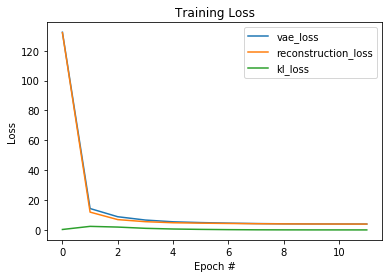

In [209]:
plot_loss(H, ['vae_loss', 'reconstruction_loss', 'kl_loss'])

#### Plot means, variances and stochastic noise in the Encoder

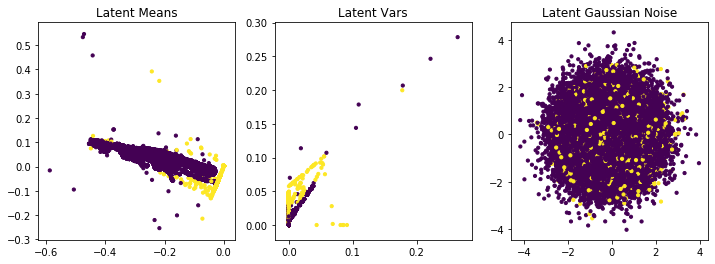

In [231]:
# obtain the Latent layer
hidden_layers = keras.backend.function(
    [vae.layers[0].input],  # inputs layer
    [vae.layers[1].output]  # encoder layer
)
latent = hidden_layers([X_train_scaled])[0] # this gives us 3 lists: means, vars and Gaussian noise

# create 3 plots (1 for each component)
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(12)
ax1.scatter(latent[0][:, 0], latent[0][:, 1], c=y_train, s=10)
ax1.set_title('Latent Means')
ax2.scatter(latent[1][:, 0], latent[1][:, 1], c=y_train, s=10)
ax2.set_title('Latent Vars')
ax3.scatter(latent[2][:, 0], latent[2][:, 1], c=y_train, s=10)
ax3.set_title('Latent Gaussian Noise');

**Note:**

The means and vars plots above vary a lot between training scenarios. It's most likely related to the weights initialisation, which set statically would make it more stable.

We can see above that the 2 classes (anomaly and not-anomaly) are somewhat visible as 2 distinct clusters.

#### Verify model's performance

In [171]:
# Reconstruct records usign the auto-encoder
reconstructed_data = vae.predict(X_test_scaled)

# calculate error of reconstructed data vs original (we are working in the scaled space)
mse = np.mean(np.power(X_test_scaled - reconstructed_data, 2), axis=1)

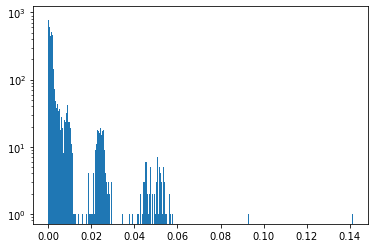

In [172]:
# plot errors on a logarithmic scale
plt.hist(mse[mse < 0.2], bins='auto', log=True)
plt.show()

In [173]:
# add errors to a dataframe
final_df = pd.DataFrame(X_test, columns=shuttle_df.columns[:9])
final_df['mse'] = mse
final_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,mse
0,54,0,81,-5,54,0,27,27,0,0.001850
1,49,0,76,-3,50,7,27,27,0,0.001649
2,47,-3,82,0,46,0,34,35,0,0.000299
3,37,0,108,-7,26,0,71,82,12,0.010436
4,51,-1,81,0,50,-16,30,32,2,0.000680


In [174]:
# verify error distribution
final_df['mse'].describe()

count    10000.000000
mean         0.004011
std          0.008542
min          0.000058
25%          0.000590
50%          0.001420
75%          0.002386
max          0.141307
Name: mse, dtype: float64

In [175]:
# find anomalies
anomaly_rate = 1 - 0.07
mse_threshold = np.quantile(final_df['mse'], anomaly_rate)
print('mse_threshold: ', mse_threshold)

mse_threshold:  0.018881344574420415


In [176]:
# set outlier binary flag
final_df['MSE_Outlier'] = 0
final_df.loc[final_df['mse'] > mse_threshold, 'MSE_Outlier'] = 1
print(f'Found total of {final_df["MSE_Outlier"].sum()} outliers') # sanity check

Found total of 700 outliers


In [177]:
# now add the actual known label, so we can validate if the predictions are correct
final_df['True_Anom_Label'] = y_test

# calculate error between the preditions and true values
final_df['IS_CORRECT'] = final_df['MSE_Outlier'] == final_df['True_Anom_Label']
final_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,mse,MSE_Outlier,True_Anom_Label,IS_CORRECT
0,54,0,81,-5,54,0,27,27,0,0.001850,0,0,True
1,49,0,76,-3,50,7,27,27,0,0.001649,0,0,True
2,47,-3,82,0,46,0,34,35,0,0.000299,0,0,True
3,37,0,108,-7,26,0,71,82,12,0.010436,0,0,True
4,51,-1,81,0,50,-16,30,32,2,0.000680,0,0,True


In [178]:
# verify how many correct and incorrect predictions do we have
final_df['IS_CORRECT'].value_counts()

True     9960
False      40
Name: IS_CORRECT, dtype: int64

In [179]:
# verify for true outliers
final_df[final_df['True_Anom_Label'] == 1]['IS_CORRECT'].value_counts()

True     698
False     38
Name: IS_CORRECT, dtype: int64

In [180]:
sklearn_f1_score = f1_score(final_df['True_Anom_Label'], final_df['MSE_Outlier'])
print('F1 Score:', sklearn_f1_score)

F1 Score: 0.9721448467966575


In [181]:
from sklearn.metrics import classification_report
print(classification_report(final_df['True_Anom_Label'], final_df['MSE_Outlier']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9264
           1       1.00      0.95      0.97       736

    accuracy                           1.00     10000
   macro avg       1.00      0.97      0.98     10000
weighted avg       1.00      1.00      1.00     10000



In [182]:
from sklearn.metrics import confusion_matrix
(TN, FN), (FP, TP) = confusion_matrix(final_df['True_Anom_Label'], final_df['MSE_Outlier'])
print('Normal classified correctly: ', TN)
print('Normal misclassified: ', FN)
print('Anomalies classified correctly: ', TP)
print('Anomalies misclassified: ', FP)

Normal classified correctly:  9262
Normal misclassified:  2
Anomalies classified correctly:  698
Anomalies misclassified:  38


#### Result for Variational Auto-Encoder:

The results are pretty good and a little bit better than in the standard AE, with more parameter tuning we could probably get it to even higher levels of performance.

In the model's run on the test-dataset above, 38 out of 736 anomalies are misclassified (which means **95%** of all true-positive samples are classified correctly). This is also reflected in the Recall score above.

Here are the most significant parts, which influenced the performance:
- as with AE - keeping model architecture simple (small number of epochs and small layer size)
- again using MinMaxScaler
- moving activation functions back to relu
- removing the regularizer term, as Gaussian noise is already taking care of that for us
- as Adam R. mentioned already, performance is good when kl_loss is very small
- model is sensitive to weights initialisation, we can see it in the plotting, where on each training, we are getting a totally different distribution of the latent space